### Case Study 3: Fuel Efficiency Versus Speed

**Objective:** Calculate the fuel efficiency in miles per gallon (MPG) or Liters per 100 km (L/100 km). Use regression to develop a model of how measured factors relate to the fuel efficiency.

Machine Learning for Engineers: [Automotive Monitoring](https://www.apmonitor.com/pds/index.php/Main/AutomotiveMonitoring)
- Description: Machine learning project with automotive data. Data includes travel distance, time, fuel rate, air flow, oxygen ratio, and other parameters available from an OBD2 interface.
- [Course Overview](https://apmonitor.com/pds)
- [Course Schedule](https://apmonitor.com/pds/index.php/Main/CourseSchedule)

<img width=400px align=left src='https://apmonitor.com/pds/uploads/Main/automotive_monitoring.png'>

In [ ]:
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms
from tqdm.keras import TqdmCallback
import keras

### Import Data and Display Column names

In [2]:
# prompt: import important libraries

import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms
from tqdm.keras import TqdmCallback
import keras

In [4]:
url = 'http://apmonitor.com/pds/uploads/Main/automotive.txt'
data = pd.read_csv(url)
data.rename(columns={'Calculated instant fuel consumption (MPG)':"MPG"},inplace=True)
data

,time,Average fuel consumption (MPG),Average fuel consumption (total) (MPG),Average fuel consumption 10 sec (MPG),Average speed (mph),MPG,Calculated instant fuel rate (gal./h),Distance travelled (miles),Distance travelled (total) (miles),Engine RPM (rpm),...,Fuel used price ($),Fuel used price (total) ($),Instant engine power (based on fuel consumption) (hp),MAF air flow rate (g/sec),Oxygen sensor 1 Wide Range Current (mA) (mA),Oxygen sensor 1 Wide Range Equivalence ratio (),Throttle position (%),Vehicle acceleration (g),Vehicle speed (mph),Unnamed: 22
0,07:57:49.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.011719,14.702742,NaN,NaN,NaN,NaN
1,07:57:50.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.588235,NaN,NaN,NaN
2,07:57:50.349,NaN,NaN,NaN,NaN,NaN,0.177214,NaN,NaN,NaN,...,NaN,NaN,1.930252,2.00,NaN,NaN,NaN,NaN,NaN,NaN
3,07:57:50.478,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,07:57:50.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49597,10:35:21.212,NaN,NaN,NaN,38.632545,0.0,NaN,86.480731,97.853975,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
49598,10:35:21.511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49599,10:35:22.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
49600,10:35:22.522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.862745,NaN,NaN,NaN


### Reformat Time

In [5]:
from datetime import datetime
dtobj = datetime.strptime(data['time'].iloc[0],'%I:%M:%S.%f')
dtobj2 = datetime.strptime(data['time'].iloc[-1],'%I:%M:%S.%f')
dataf = data.copy()
dataf['time'] = data['time'].apply(func=lambda x: datetime.strptime(x,'%I:%M:%S.%f'))
dataf['timetot'] = dataf['time'].apply(lambda x:(x-dtobj).microseconds/10**6+(x-dtobj).seconds)
dataf['timetot'].sample(5)

,timetot
42137,7611.466
45990,8236.939
1942,308.791
36744,6733.750
32302,6008.137


### Plot and Visualize the Data

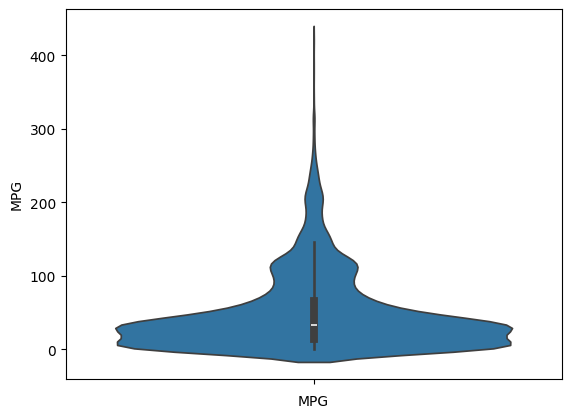

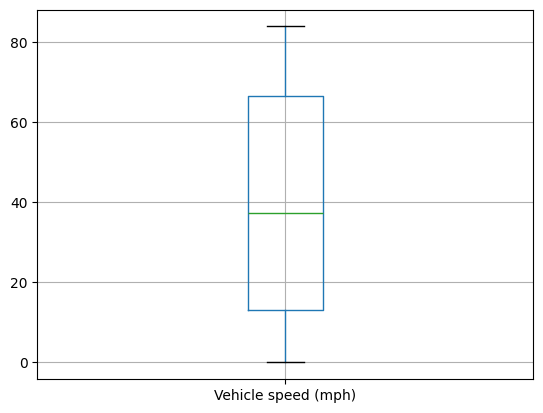

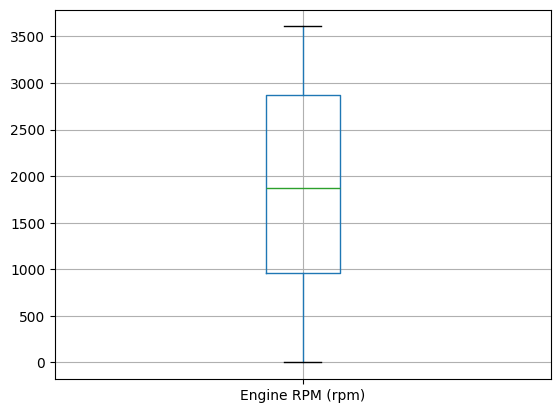

In [6]:
label = 'MPG'
#predict MPG from RPM, and speed
sns.violinplot(data=dataf[label])
plt.xlabel(label)
plt.show()
dataf.boxplot('Vehicle speed (mph)')
plt.show()
dataf.boxplot('Engine RPM (rpm)')
plt.show()

## Reformat Data
Use Vehicle Speed, Acceleration, and RPM as features. Visualize the effects of well-known aspects of driving on fuel efficiency.

In [7]:
rpm = 'Engine RPM (rpm)'
speed = 'Vehicle speed (mph)'
speeds = dataf[speed].dropna()
acel = 'Vehicle acceleration (g)'
gal = 'Fuel used (gallon)'
alls = [acel,speed,rpm,label]
dataf[alls].isna().sum()
datan = dataf[alls].copy().fillna(method='ffill').drop_duplicates()
datan = datan[datan[label]>0]
datan = datan[datan[label]<45] #Anything higher than this is most likely coasting
datan.sample(20)

<ipython-input-7-025d07c09f43>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datan = dataf[alls].copy().fillna(method='ffill').drop_duplicates()


,Vehicle acceleration (g),Vehicle speed (mph),Engine RPM (rpm),MPG
31378,0.009264,64.622604,2776.0,34.406428
10743,0.009298,69.593574,2985.0,34.722183
42278,-0.022266,69.593574,2985.0,30.357584
10754,-0.019128,68.350831,2949.0,31.036995
30208,0.026328,47.845582,2035.0,22.075667
6756,0.118614,22.990734,2371.0,29.125622
20189,0.000000,0.621371,962.0,2.075613
6033,0.141873,9.320568,2084.0,7.725055
47793,-0.159225,12.427424,1195.0,33.133891
12054,0.000000,76.428657,3281.0,25.898603


### Show Heatmap

In [ ]:
# sns.heatmap(dataf.copy().fillna(method='ffill').drop_duplicates().corr(),annot=False,fmt='f')
# plt.show()

### Create Pairplot

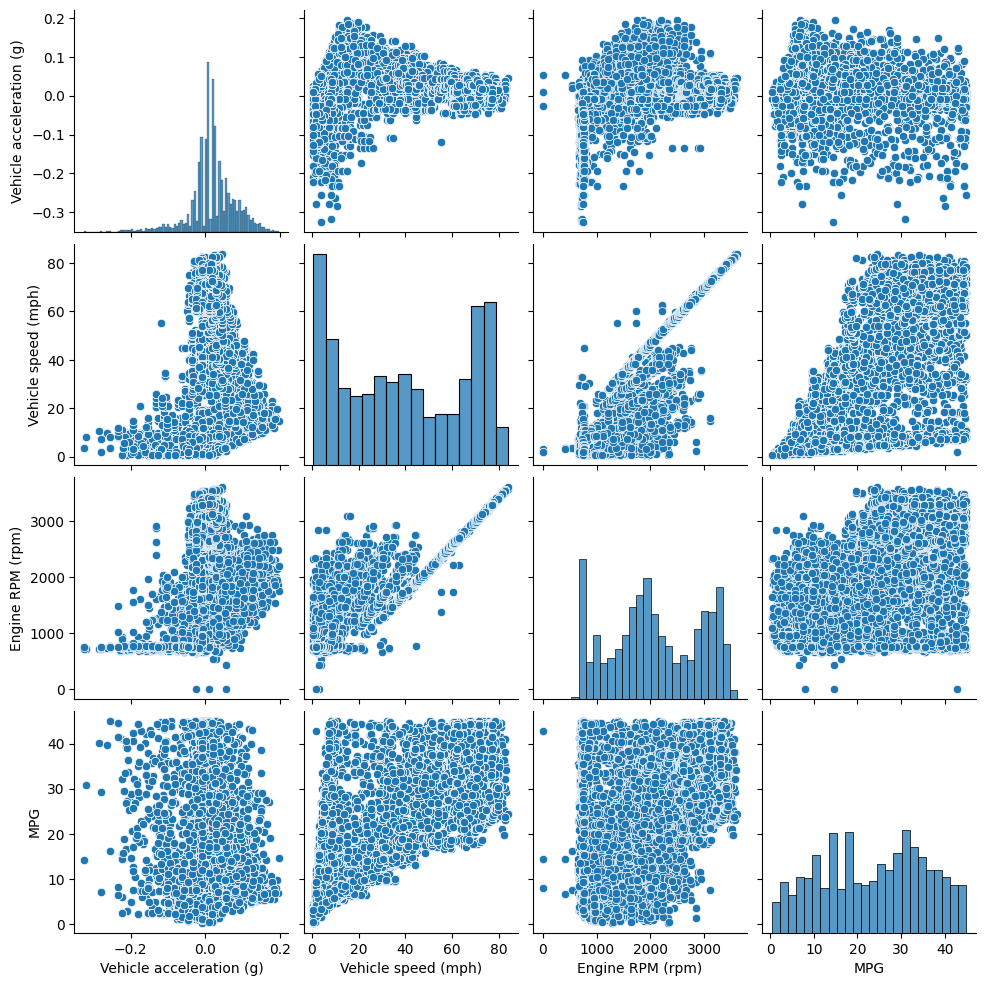

In [9]:
sns.pairplot(datan)
plt.show()

### Scale Data, Train model, and show accuracy

0.156 3.063, r2=0.8743636233773533


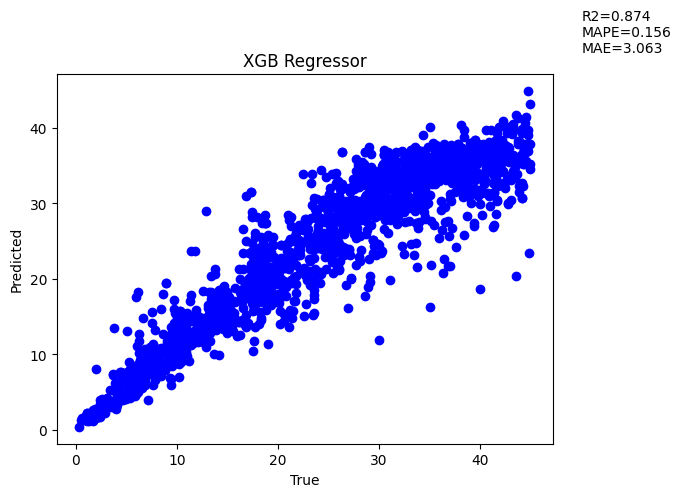

In [10]:
s = mms()

use = alls.copy()
use.remove('MPG')

dataS = pd.DataFrame(np.sqrt(np.array(s.fit_transform(datan))), columns =alls)
Xtrain, Xtest, ytrain, ytest = tts(dataS[use], dataS[label], test_size = .2, random_state = 87)

model = xgb.XGBRegressor()

m = model.fit(dataS[use], dataS[label])

datatest = Xtest.join(ytest,how='right')
yp = m.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform((datatest.values)**2),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap.values**2),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.text(50,50,f'R2={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')
# linear model
reg = LinearRegression().fit(dataS[use], dataS[label])
ypr = reg.predict(datatest[use])
r2lin = r2(datatest[label],ypr)

### Create a Neural Network to compare performance with XGBoost Regression

In [11]:
mod = Sequential()
mod.add(Dense(3,input_shape=(Xtrain.shape[1],),activation='relu'))
mod.add(Dense(1,activation='linear'))
mod.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
mod.compile(optimizer='sgd', loss='mse')
history = mod.fit(Xtrain,ytrain,epochs = 100, verbose=True, \
                  validation_data=(Xtest,ytest),\
                  callbacks=[TqdmCallback(verbose=1), \
                             EarlyStopping(monitor = 'loss',patience=4)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0214 - val_loss: 0.0210
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0207 - val_loss: 0.0208
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - val_loss: 0.0207
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.0206
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0205
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0210 - val_loss: 0.0203
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215 - val_loss: 0.0202
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━━

### Plot Learning History

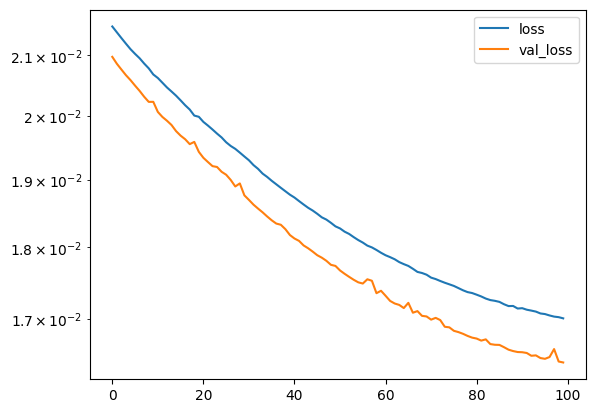

In [14]:
plt.semilogy(history.history['loss'],label='loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
mod.save('Model_3var.h5')

In [18]:
import keras
from keras.models import load_model
from keras.losses import MeanSquaredError

# ... (rest of your code)

# Load the model and explicitly specify the loss function
mod = load_model('Model_3var.h5', custom_objects={'mse': MeanSquaredError})

# ... (rest of your code)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.1884 4.468, r2=0.6327692063909712


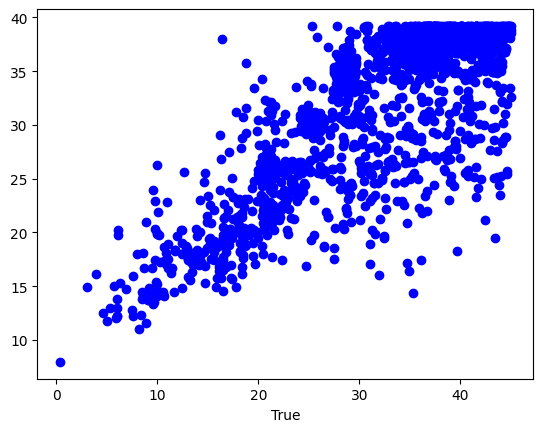

In [19]:
#mod = keras.models.load_model('Model_3var.h5')
yp = mod.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform(datatest),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.xlabel('True')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')

### View Predictions

RPM,Speed,Acceleration median values
0.744363176884441 0.6747028090922809 0.8112128339807488


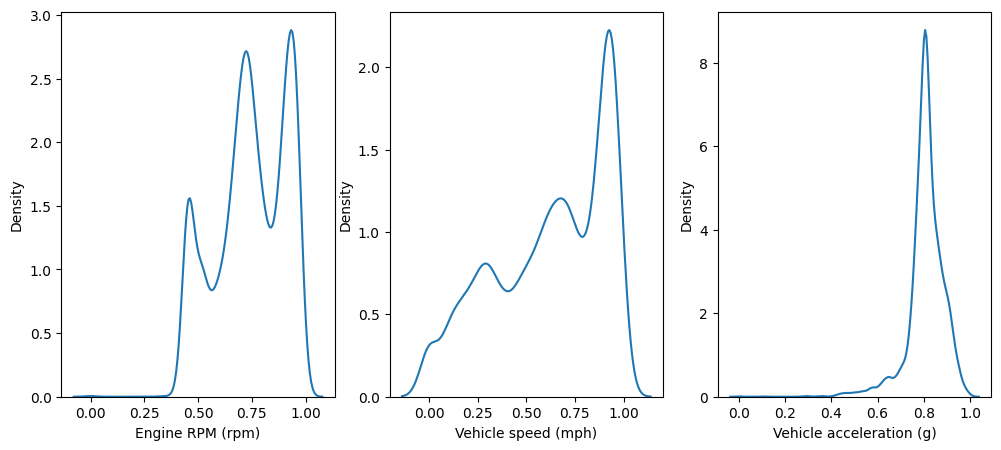

In [20]:
# XGB Regression
rpmmed = np.ones(datan.shape[0])*dataS[rpm].median()
speedmed = np.ones(datan.shape[0])*dataS[speed].median()
acelmed = np.ones(datan.shape[0])*dataS[acel].median()
print('RPM,Speed,Acceleration median values')
print(dataS[rpm].median(),dataS[speed].median(),dataS[acel].median())
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.kdeplot(dataS[rpm])
plt.subplot(1,3,2)
sns.kdeplot(dataS[speed])
plt.subplot(1,3,3)
sns.kdeplot(dataS[acel])
plt.show()

## Display Extrapolations with one variable

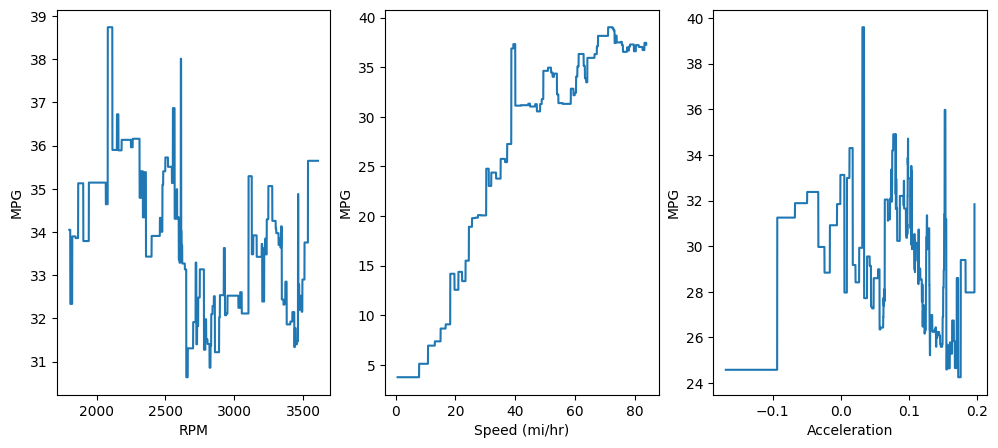

In [21]:
# Use the XGBoost model since it performed better
n = datan.shape[0]
rpmvar = np.linspace(.5,1,n)
speedvar = np.linspace(0,1,n)
acelvar = np.linspace(.3,1,n)
rpmdf = pd.DataFrame(np.array([acelmed,speedmed,rpmvar]).T,columns=use)
speeddf = pd.DataFrame(np.array([acelmed,speedvar,rpmmed]).T,columns=use)
aceldf = pd.DataFrame(np.array([acelvar,speedmed,rpmmed]).T,columns=use)
rpmpred = m.predict(rpmdf)
speedpred = m.predict(speeddf)
acelpred = m.predict(aceldf)
trrpm = pd.DataFrame(s.inverse_transform(rpmdf.join(pd.DataFrame(rpmpred))),columns = use+[label])
trspeed = pd.DataFrame(s.inverse_transform(speeddf.join(pd.DataFrame(speedpred))),columns = use+[label])
tracel = pd.DataFrame(s.inverse_transform(aceldf.join(pd.DataFrame(acelpred))),columns = use+[label])

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(trrpm[rpm],trrpm[label])
plt.ylabel('MPG'); plt.xlabel('RPM')
plt.subplot(1,3,2)
plt.plot(trspeed[speed],trspeed[label])
plt.ylabel('MPG'); plt.xlabel('Speed (mi/hr)')
plt.subplot(1,3,3)
plt.plot(tracel[acel],tracel[label])
#tracel.plot(x=acel,y=label)
plt.ylabel('MPG'); plt.xlabel('Acceleration')
plt.show()

### Discussion

The three cross sections show the MPG varying a single variable while the other variables are held constant at a median value. This method inherently misses important behavior because the other values are restricted to the median. However, the trends are visible and most likely carry throughout portions of the 4-d model, even if the actual magnitudes vary. Some observations:

- The highest MPG (fuel efficiency) is at lower RPM for the engine. The data where the car is coasting may influence this higher trend at lower RPM.
- The highest MPG is at the highest speed with highway driving. City driving fuel efficiency is lower due to braking action and lower average velocity.
- Fuel efficiency decreases with higher acceleration.

### 4D Figure with 3D + Color

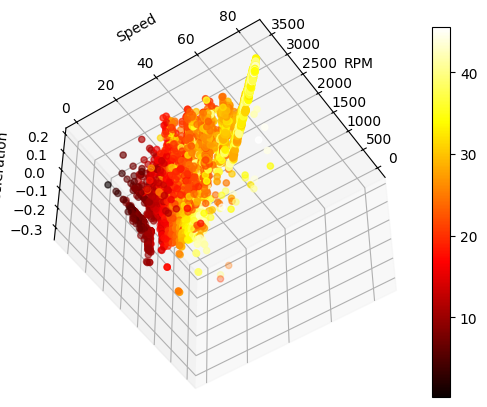

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
datass = dataS.copy()
datass[label] = m.predict(dataS[use])
datainv = pd.DataFrame(s.inverse_transform(datass),columns = use+[label])
img = ax.scatter(datainv[rpm],datainv[speed],datainv[acel],c=datainv[label],cmap = plt.hot())
fig.colorbar(img)
plt.xlabel('RPM')
plt.ylabel('Speed')
ax.set_zlabel('Acceleration')
ax.view_init(azim=34,elev = -51)
plt.show()